In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import os

In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train_scaled': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test_scaled': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# Define the data directory
data_dir = 'GG_4A'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train_scaled', 'test_scaled']}
#image_datasets

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train_scaled', 'test_scaled']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_scaled', 'test_scaled']}
print(dataset_sizes)

class_names = image_datasets['train_scaled'].classes
class_names

{'train_scaled': 320, 'test_scaled': 80}


['combat', 'destroyedbuilding', 'fire', 'humanitarianaid', 'militaryvehicles']

In [5]:
weights=torchvision.models.ResNet18_Weights.DEFAULT

In [8]:
# Load the pre-trained ResNet-18 model
model = torchvision.models.resnet18(weights=weights)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train_scaled', 'test_scaled']:
        if phase == 'train_scaled':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train_scaled'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train_scaled':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train_scaled Loss: 3.0947 Acc: 0.2219
test_scaled Loss: 1.4746 Acc: 0.5000
train_scaled Loss: 1.3086 Acc: 0.4875
test_scaled Loss: 0.8390 Acc: 0.7250
train_scaled Loss: 1.0877 Acc: 0.5938
test_scaled Loss: 0.5662 Acc: 0.7875
train_scaled Loss: 1.0440 Acc: 0.6250
test_scaled Loss: 0.5048 Acc: 0.8375
train_scaled Loss: 1.0556 Acc: 0.5813
test_scaled Loss: 0.4750 Acc: 0.8500
train_scaled Loss: 0.9365 Acc: 0.6531
test_scaled Loss: 0.4643 Acc: 0.8500
train_scaled Loss: 0.9164 Acc: 0.6750
test_scaled Loss: 0.5797 Acc: 0.7875
train_scaled Loss: 0.8803 Acc: 0.6688
test_scaled Loss: 0.4155 Acc: 0.8625
train_scaled Loss: 1.0159 Acc: 0.6594
test_scaled Loss: 0.3647 Acc: 0.8375
train_scaled Loss: 0.8861 Acc: 0.6969
test_scaled Loss: 0.4787 Acc: 0.8625
Training complete!


In [10]:
# Save the model
torch.save(model.state_dict(), 'model_weights1.pth')
torch.save(model, 'model1.pth')

In [27]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model = torch.load('model1.pth', map_location=torch.device('cuda'))
model.eval()  # Set the model to evaluation mode

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 5)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:5]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:5]

d:\Softwares\envs\GG_2526\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Softwares\envs\GG_2526\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Load and preprocess the unseen image
image_path = 'd1.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [32]:
# Move the input batch to the same device as the model
input_batch = input_batch.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['combat', 'destroyedbuilding', 'fire', 'humanitarianaid', 'militaryvehicles']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: destroyedbuilding


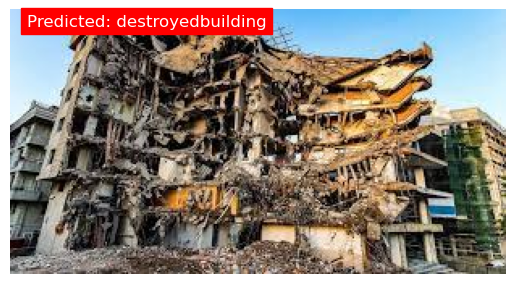

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()